In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
import xgboost as xgb
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.options.display.float_format = '{:,.2f}'.format

In [33]:
data = pd.read_csv(
    'dataset_wparticipant_v2.csv',
    delimiter=';',
    dtype=str,
    usecols=[
        "lot_id",
        "fw_total_price_wdiscount",
        "sw_total_price_wdiscount",
        "ad_total_sum",
        "total_amount",

        # integers
        "total_count",        
        "ad_lots_count",

        # binary
        "is_union_lots",
        "is_dumping",
        "is_consulting_services",
        "is_disable_person_advertisement",
        "ad_disable_person_id",
        "ad_purchase_type_id",
        "participant_is_have_website",
        "participant_is_quazi",
        "participant_is_national_company",
        "participant_is_association_with_disabilities",
        "participant_is_supplier",
        "participant_is_state_monopoly",
        "participant_is_natural_monopoly",
        "participant_is_small_employer",
        "participant_is_single_org",
        
        # categorical
        "lot_status_id",
        "plan_trade_method_id",
        "psd_sign",
        "single_org_sign",
        "is_light_industry",
        "is_construction_work",
        "ad_trade_method_id",
        "ad_subject_type_id",
        "ad_trade_type_id",
        "ad_single_org_sign",
        "ad_is_light_industry",
        "ad_is_construction_work",
        "participant_creation_date",
        "participant_registration_year",
        "participant_krp_code",
        "participant_oked_list",
        "participant_kse_code",

        # additional
        "ad_start_date",
        "ad_repeat_start_date",
        "ad_end_date",
        "ad_repeat_end_date",
        "ad_publish_date",

        "ad_fin_years",
        "ad_katos",
        "participant_registration_date",
        "participant_kato_list",
        "participant_kopf_code",
        "participant_branches",
        "participant_parent_company",
        
        # 'customer_id',
        # fact_trade_method_id,
        # plans_ids
        # ad_customer_id - не заполнялось
        # advertisement_status_id - оставили только 350, завершенные закупки
        # ad_itogi_date_public - известно только после окончания закупки
        # participant_id
        # participant_bin
        # participant_iin
        # participant_country - только Казахстан
        # participant_is_organizer
        # participant_is_customer
        # participant_is_resident - не особо заполняется
        # participant_supplier_type - особо не заполняется
        # participant_is_world_company - особо не заполняется
        # participant_is_patronymic_producer - везде одно значение
        # participant_is_patronymic_supplier - везде одно
        
    ]
)
data.head()

,lot_id,fw_total_price_wdiscount,sw_total_price_wdiscount,lot_status_id,is_union_lots,total_count,total_amount,is_dumping,plan_trade_method_id,psd_sign,...,participant_is_supplier,participant_krp_code,participant_branches,participant_parent_company,participant_oked_list,participant_kse_code,participant_is_state_monopoly,participant_is_natural_monopoly,participant_is_small_employer,participant_is_single_org
0,29526032,4160393.3600,4186892.6800,360,0,1,4907281.6200,1,188,18,...,1,0,NaN,NaN,36000,5,0,1,0,0
1,29525894,13900.0000,15900.0000,360,0,100,20000.0000,0,3,0,...,1,0,NaN,NaN,85100,5,0,1,1,0
2,29524214,209999.0000,249000.0000,360,0,1,250000.0000,0,3,0,...,0,0,NaN,NaN,84113,5,0,0,0,0
3,29520431,2400.0000,2790.0000,360,0,30,3000.0000,0,3,0,...,0,0,NaN,NaN,84114,5,0,0,0,0
4,29415829,169000.0000,171600.0000,360,0,5,214285.7000,0,3,0,...,1,0,NaN,NaN,85520,5,0,0,1,0


In [34]:
quantiles = [0.0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]

In [35]:
for numeric_field in (
    "fw_total_price_wdiscount",
    "sw_total_price_wdiscount",
    "ad_total_sum",
    "total_amount",

    "total_count",        
    "ad_lots_count",
):
    data[numeric_field] = pd.to_numeric(data[numeric_field])

In [342]:
data = data[data.lot_status_id == '360'] # ток состоявшиеся лоты

In [36]:
data.loc[data.sw_total_price_wdiscount.isna(), "sw_total_price_wdiscount"] = data.loc[data.sw_total_price_wdiscount.isna(), "total_amount"]

In [37]:
# 1163 rows will be removed; закупки по которым некорректно сидела информация на портале - например спуталось кол-во и цена за один товар, полная цена
data = data[~(data.sw_total_price_wdiscount < data.fw_total_price_wdiscount)]

In [38]:
pd.DataFrame({
    "Quantile": quantiles,
    "fw_total_price_wdiscount": data.fw_total_price_wdiscount.quantile(quantiles)
})

,Quantile,fw_total_price_wdiscount
0.00,0.00,0.00
0.01,0.01,0.00
0.05,0.05,0.00
0.10,0.10,"1,440.00"
0.25,0.25,"9,200.00"
0.50,0.50,"42,000.00"
0.75,0.75,"202,500.00"
0.90,0.90,"1,008,133.20"
0.95,0.95,"3,019,500.00"
0.99,0.99,"24,426,215.00"


In [48]:
data = data[~(data.fw_total_price_wdiscount <= data.fw_total_price_wdiscount.quantile(0.10))] # мы не занимаемся благотворительностью

In [49]:
data = data[~(data.fw_total_price_wdiscount > data.total_amount)] # эти каким-то боком умудрились продать свои услуги дороже чем было выделено из бюджета

In [50]:
pd.DataFrame({
    "Quantile": quantiles,
    "(total_amount / fw_total_price_wdiscount)": (data['total_amount'] / data['fw_total_price_wdiscount']).quantile(quantiles)
})

,Quantile,(total_amount / fw_total_price_wdiscount)
0.00,0.00,1.00
0.01,0.01,1.00
0.05,0.05,1.00
0.10,0.10,1.03
0.25,0.25,1.12
0.50,0.50,1.34
0.75,0.75,1.69
0.90,0.90,2.12
0.95,0.95,2.47
0.99,0.99,3.65


In [51]:
# эти уебки слишком сильно сбрасывают цену, на кол - безосновательно скидывают, изучали. 55к таких
data = data[~((data['total_amount'] / data['fw_total_price_wdiscount']) > (data['total_amount'] / data['fw_total_price_wdiscount']).quantile(0.99))]

In [62]:
len(data[data.fw_total_price_wdiscount == data.total_amount]) / len(data), (data.fw_total_price_wdiscount / data.total_amount).quantile(quantiles)

(0.036202481714487256,
 0.00   0.27
 0.01   0.33
 0.05   0.42
 0.10   0.48
 0.25   0.60
 0.50   0.75
 0.75   0.89
 0.90   0.97
 0.95   1.00
 0.99   1.00
 1.00   1.00
 dtype: float64)

In [63]:
data = data[~(data.fw_total_price_wdiscount == data.total_amount)] #  пока не совсем понятно как с такими записями работать, и сильно ли это повлияет

In [72]:
quantile_values = data['total_amount'].quantile(quantiles)
cumulative_lots = [data['total_amount'].le(value).sum() for value in quantile_values]
lots_in_quantile = np.diff([0] + cumulative_lots)

data['unearned_revenue'] = data['sw_total_price_wdiscount'] - data['fw_total_price_wdiscount']
data['unearned_revenue_pct'] = (data['sw_total_price_wdiscount'] / data['fw_total_price_wdiscount'] - 1) * 100

range_start = [0] + list(quantile_values)[:-1]
range_end = list(quantile_values)

# total unearned revenue within each quantile range
unearned_revenue = []
cumulative_unearned_revenue = []
non_cumulative_unearned_revenue_pct = []
cumulative_sum = 0

for start, end in zip(range_start, range_end):
    unearned_sum = data[(data['total_amount'] > start) & (data['total_amount'] <= end)]['unearned_revenue'].sum()
    unearned_revenue.append(unearned_sum)

    cumulative_sum += unearned_sum
    cumulative_unearned_revenue.append(cumulative_sum)

    avg_pct = data[(data['total_amount'] > start) & (data['total_amount'] <= end)]['unearned_revenue_pct'].quantile(0.667) if not data[(data['total_amount'] > start) & (data['total_amount'] <= end)].empty else 0
    non_cumulative_unearned_revenue_pct.append(avg_pct)

unearned_revenue_summary = pd.DataFrame({
    "Quantile": quantiles,
    "LotQuantileBound": quantile_values,
    "CumulativeLotsCount": cumulative_lots,
    "LotsInQuantile": lots_in_quantile,
    "UnearnedRevenue": unearned_revenue,
    "CumulativeUnearnedRevenue": cumulative_unearned_revenue,
    "NonCumulativeUnearnedRevenueQ66percent": non_cumulative_unearned_revenue_pct
})

unearned_revenue_summary

,Quantile,LotQuantileBound,CumulativeLotsCount,LotsInQuantile,UnearnedRevenue,CumulativeUnearnedRevenue,NonCumulativeUnearnedRevenueQ66percent
0.00,0.00,"1,446.40",1,1,0.10,0.10,0.01
0.01,0.01,"2,490.00",51773,51772,"8,372,223.85","8,372,223.95",10.71
0.05,0.05,"4,907.08",258508,206735,"82,637,387.61","91,009,611.56",16.80
0.10,0.10,"8,000.00",527033,268525,"191,759,855.27","282,769,466.83",17.65
0.25,0.25,"22,321.50",1293660,766627,"1,115,449,852.44","1,398,219,319.27",16.16
0.50,0.50,"84,000.00",2589500,1295840,"5,203,651,850.92","6,601,871,170.19",13.82
0.75,0.75,"355,221.24",3877615,1288115,"17,680,904,321.84","24,282,775,492.03",12.00
0.90,0.90,"1,696,428.40",4653145,775530,"40,372,357,850.69","64,655,133,342.72",10.61
0.95,0.95,"4,742,395.20",4911645,258500,"43,174,945,101.28","107,830,078,444.00",9.02
0.99,0.99,"35,614,678.65",5118451,206806,"126,436,485,202.13","234,266,563,646.13",7.35


In [86]:
data[
    [
        "sw_total_price_wdiscount",
        "ad_total_sum",
        "total_amount"
    ]
].corr()

# ad_total_sum и total_amount сильно коррелируют, можно исключить одну из них, та что коррелирует меньше с целевой
# таким образом, исключаем ad_total_sum

,sw_total_price_wdiscount,ad_total_sum,total_amount
sw_total_price_wdiscount,1.00,0.73,1.00
ad_total_sum,0.73,1.00,0.73
total_amount,1.00,0.73,1.00


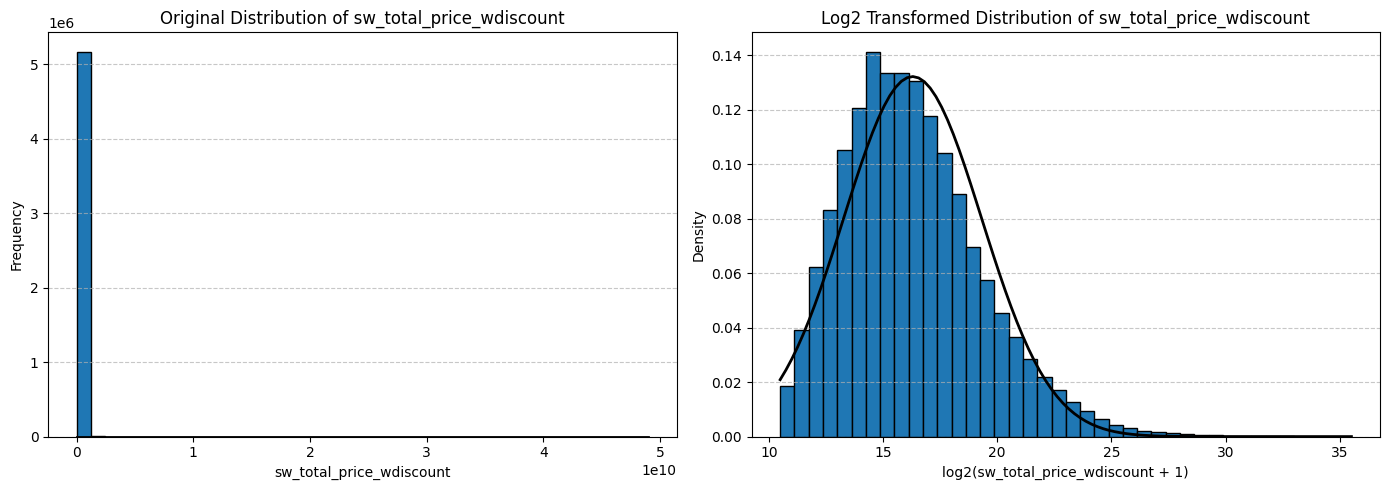

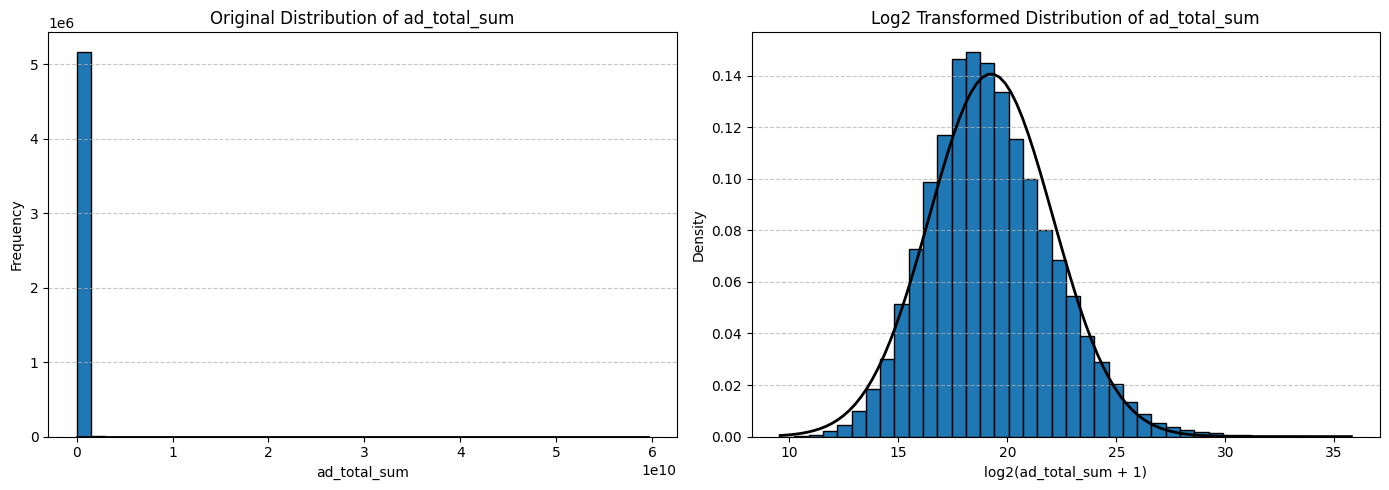

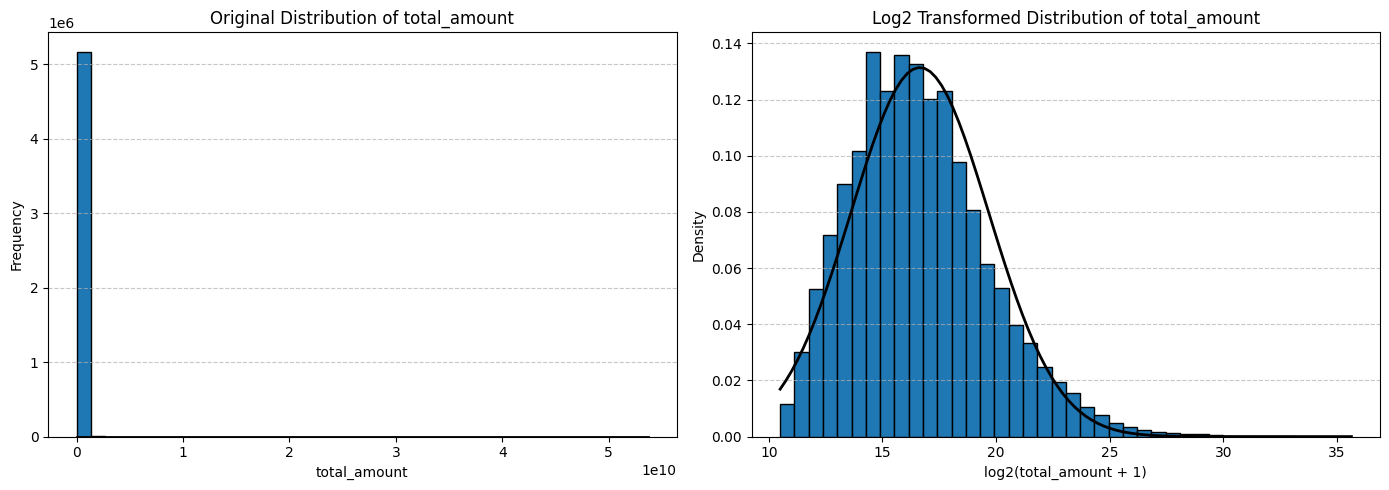

In [90]:
for col in ["sw_total_price_wdiscount", "ad_total_sum", "total_amount"]:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].hist(data[col], bins=40, edgecolor="black")

    mu, std = norm.fit(data[col])
    x = np.linspace(data[col].min(), data[col].max(), 100)
    p = norm.pdf(x, mu, std)
    ax[0].plot(x, p, 'k', linewidth=2)

    ax[0].set_title(f"Original Distribution of {col}")
    ax[0].set_xlabel(col)
    ax[0].set_ylabel("Frequency")
    ax[0].grid(axis='y', linestyle='--', alpha=0.7)

    # log_data = np.log10(data[col] + 1)
    # ax[1].hist(log_data, bins=40, edgecolor="black", density=True)
    
    # mu, std = norm.fit(log_data)
    # x = np.linspace(log_data.min(), log_data.max(), 100)
    # p = norm.pdf(x, mu, std)
    # ax[1].plot(x, p, 'k', linewidth=2)

    # ax[1].set_title(f"Log10 Transformed Distribution of {col}")
    # ax[1].set_xlabel(f"log10({col} + 1)")
    # ax[1].set_ylabel("Frequency")
    # ax[1].grid(axis='y', linestyle='--', alpha=0.7)

    
    log2_data = np.log2(data[col] + 1)
    ax[1].hist(log2_data, bins=40, edgecolor="black", density=True)
    mu, std = norm.fit(log2_data)
    x = np.linspace(log2_data.min(), log2_data.max(), 100)
    p = norm.pdf(x, mu, std)
    ax[1].plot(x, p, 'k', linewidth=2)
    ax[1].set_title(f"Log2 Transformed Distribution of {col}")
    ax[1].set_xlabel(f"log2({col} + 1)")
    ax[1].set_ylabel("Density")
    ax[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

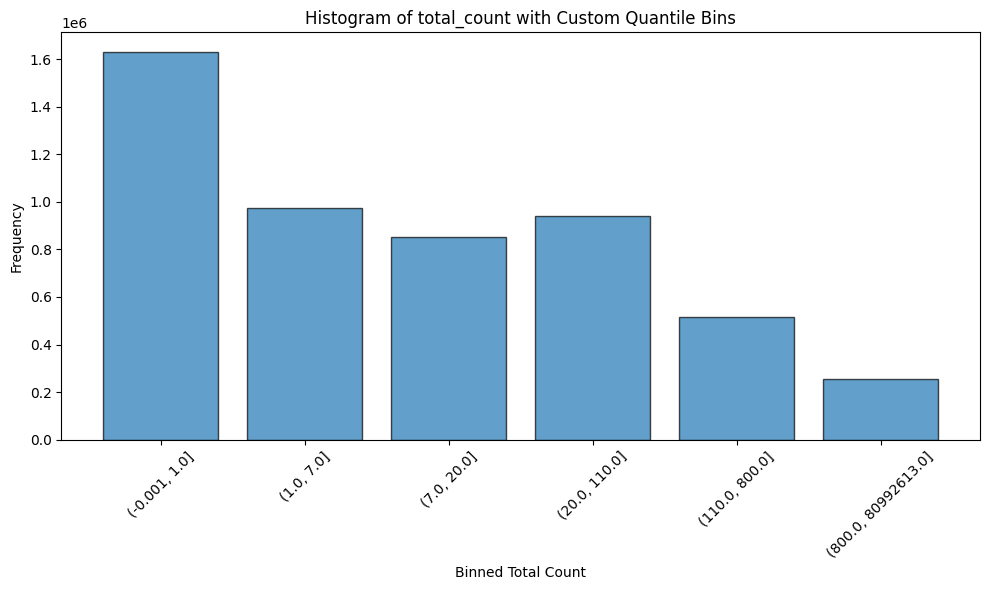

(      Quantile         Bound
 0.00      0.00          0.00
 0.01      0.01          1.00
 0.05      0.05          1.00
 0.10      0.10          1.00
 0.25      0.25          1.00
 0.50      0.50          7.00
 0.75      0.75         50.00
 0.90      0.90        250.00
 0.95      0.95        800.00
 0.99      0.99      6,672.00
 1.00      1.00 80,992,613.00,
            total_count    count
 0        (-0.001, 1.0]  1630561
 1           (1.0, 7.0]   972996
 2          (7.0, 20.0]   852852
 3        (20.0, 110.0]   941965
 4       (110.0, 800.0]   515294
 5  (800.0, 80992613.0]   256485)

In [247]:
quantile_bins = np.unique(data['total_count'].quantile([0.0, 0.05, 0.5, 0.65, 0.85, 0.95, 1]))
bin_counts = pd.cut(data['total_count'], bins=quantile_bins, include_lowest=True).value_counts(sort=False).reset_index()


plt.figure(figsize=(10, 6))
plt.bar(
    bin_counts['total_count'].astype(str), bin_counts['count'], edgecolor='black', alpha=0.7
)
plt.xticks(rotation=45)
plt.title("Histogram of total_count with Custom Quantile Bins")
plt.xlabel("Binned Total Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


pd.DataFrame({
    "Quantile": quantiles,
    "Bound": data['total_count'].quantile(quantiles)
}), bin_counts

In [304]:
data[~data.participant_is_quazi.isna()]

,lot_id,fw_total_price_wdiscount,sw_total_price_wdiscount,lot_status_id,is_union_lots,total_count,total_amount,is_dumping,plan_trade_method_id,psd_sign,...,participant_is_state_monopoly,participant_is_natural_monopoly,participant_is_small_employer,participant_is_single_org,unearned_revenue,unearned_revenue_pct,optimal_bin,total_count_quantile,total_count_quantile_bin,total_count_quantile_code
0,29526032,"4,160,393.36","4,186,892.68",360,0,1,"4,907,281.62",1,188,18,...,0,1,0,0,"26,499.32",0.64,"(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",0
1,29525894,"13,900.00","15,900.00",360,0,100,"20,000.00",0,3,0,...,0,1,1,0,"2,000.00",14.39,"(50.0, 250.0]","(50.0, 250.0]","(50.0, 250.0]",3
2,29524214,"209,999.00","249,000.00",360,0,1,"250,000.00",0,3,0,...,0,0,0,0,"39,001.00",18.57,"(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",0
3,29520431,"2,400.00","2,790.00",360,0,30,"3,000.00",0,3,0,...,0,0,0,0,390.00,16.25,"(7.0, 50.0]","(7.0, 50.0]","(7.0, 50.0]",2
4,29415829,"169,000.00","171,600.00",360,0,5,"214,285.70",0,3,0,...,0,0,1,0,"2,600.00",1.54,"(1.0, 7.0]","(1.0, 7.0]","(1.0, 7.0]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6034216,29546364,"21,800.00","28,700.00",360,0,100,"45,000.00",0,3,0,...,0,1,0,0,"6,900.00",31.65,"(50.0, 250.0]","(50.0, 250.0]","(50.0, 250.0]",3
6034217,29538544,"6,960.00","7,000.00",360,0,20,"8,000.00",0,3,0,...,0,0,0,0,40.00,0.57,"(7.0, 50.0]","(7.0, 50.0]","(7.0, 50.0]",2
6034218,29535140,"42,000.00","52,500.00",360,0,1,"62,500.00",0,3,0,...,0,0,0,0,"10,500.00",25.00,"(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",0
6034219,29532943,"2,981.00","3,775.00",360,0,1,"3,900.00",0,3,0,...,0,0,0,0,794.00,26.64,"(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]",0


In [333]:
data = data[~data.participant_is_quazi.isna()] # remove 73 rows

group_columns = [
    "is_union_lots",
    "is_dumping",
    "is_consulting_services",
    # "is_disable_person_advertisement",
    "ad_disable_person_id",
    "ad_purchase_type_id",
    "participant_is_have_website",
    "participant_is_quazi",
    "participant_is_national_company",
    "participant_is_association_with_disabilities",
    "participant_is_supplier",
    "participant_is_state_monopoly",
    "participant_is_natural_monopoly",
    "participant_is_small_employer",
    "participant_is_single_org",
]

data[group_columns] = data[group_columns].astype(int)


In [334]:
grouped_results = []

for col in group_columns:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results.append(temp_df)

combined_data = pd.concat(grouped_results, axis=0, ignore_index=True)
combined_data[['name', 'value', 'count']]

,name,value,count
0,is_union_lots,0,5087666
1,is_union_lots,1,82414
2,is_dumping,0,4936716
3,is_dumping,1,233364
4,is_consulting_services,0,5140100
5,is_consulting_services,1,29980
6,ad_disable_person_id,0,5081985
7,ad_disable_person_id,1,88095
8,ad_purchase_type_id,0,5148143
9,ad_purchase_type_id,1,21937


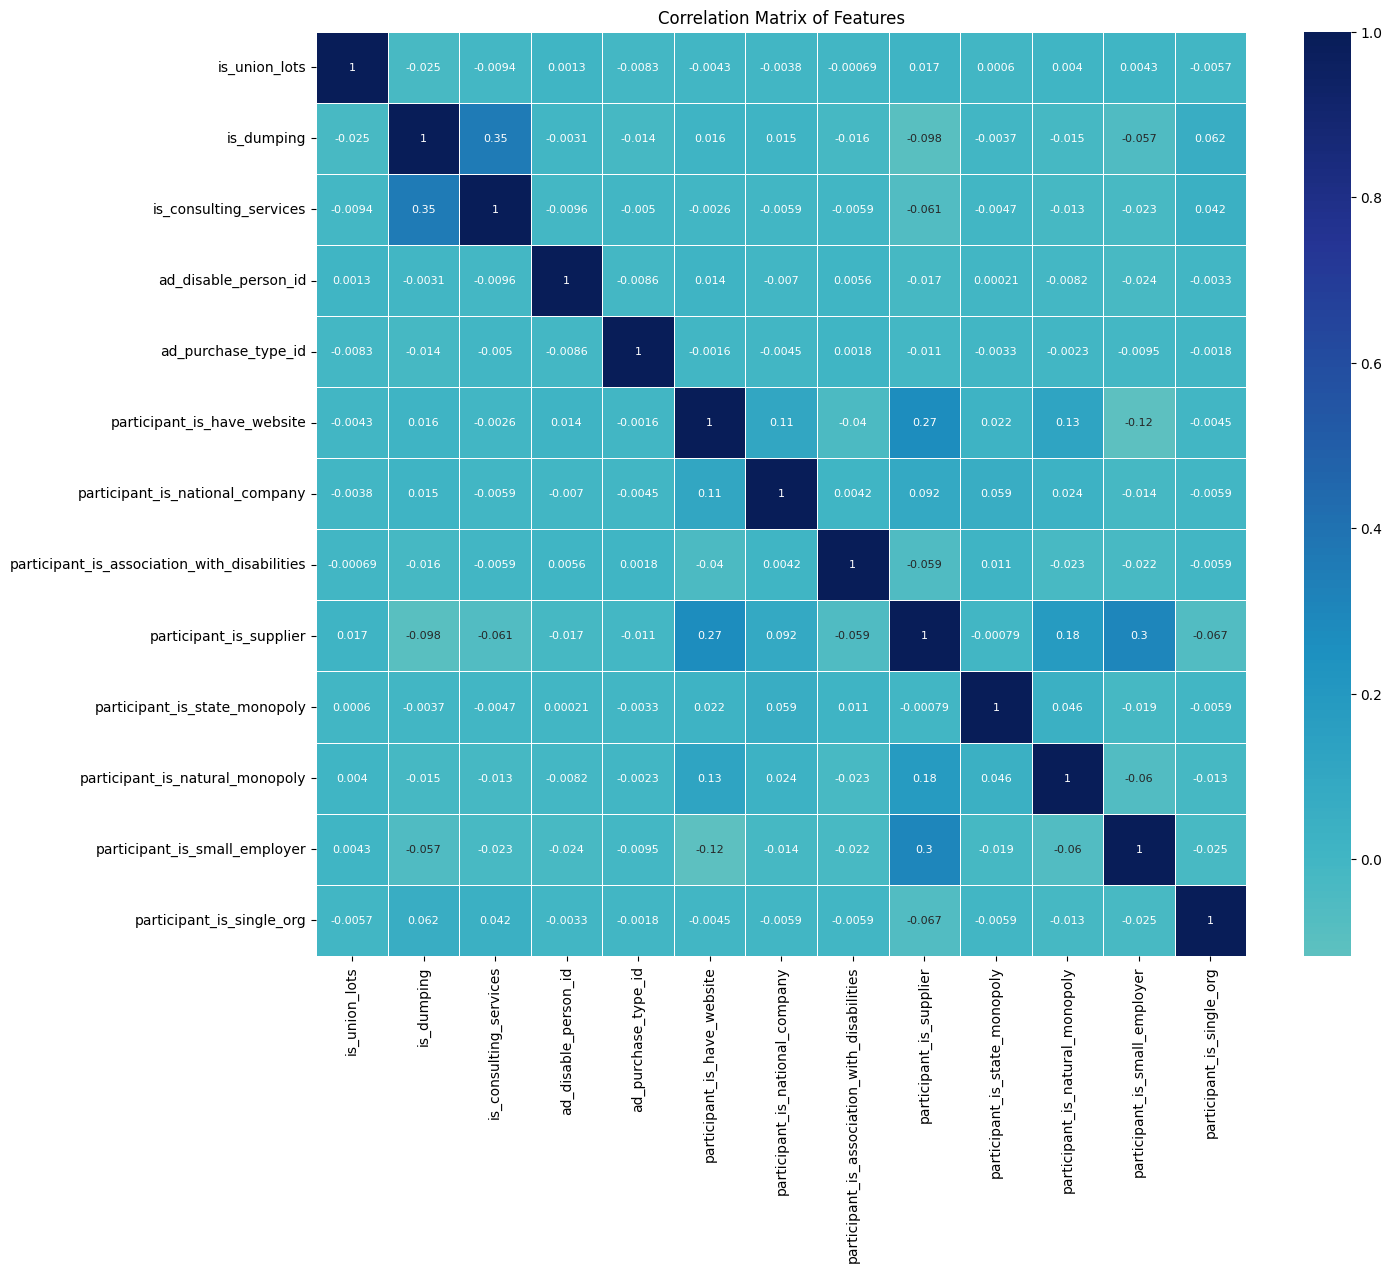

In [336]:
plt.figure(figsize=(15, 12))

sns.heatmap(
    data[group_columns].drop(columns=["participant_is_quazi"]).corr(),
    annot=True, cmap='YlGnBu', center=0, linewidths=0.5, annot_kws={"size": 8}
)

plt.title('Correlation Matrix of Features')
plt.show()

In [337]:
columns_check_correlation = [i for i in group_columns if i not in ["is_disable_person_advertisement", "participant_is_quazi"]]
vif_values = [
    variance_inflation_factor(data[columns_check_correlation].dropna().values, i) 
    for i in range(data[columns_check_correlation].shape[1])
]

for var, vif in zip(columns_check_correlation, vif_values):
    print(f"{var:30s}     {vif:5.2f}")

is_union_lots                       1.01
is_dumping                          1.17
is_consulting_services              1.15
ad_disable_person_id                1.01
ad_purchase_type_id                 1.00
participant_is_have_website         1.49
participant_is_national_company      1.03
participant_is_association_with_disabilities      1.00
participant_is_supplier             1.98
participant_is_state_monopoly       1.04
participant_is_natural_monopoly      1.14
participant_is_small_employer       1.34
participant_is_single_org           1.01


In [351]:
grouped_results_categorical = []

for col in ["plan_trade_method_id", "ad_trade_method_id"]:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results_categorical.append(temp_df)

pd.concat(grouped_results_categorical, axis=0, ignore_index=True)[['name', 'value', 'count']]
# лучше дропнуть plan_trade_method_id - NaN много, ad_trade_method_id - хорошая альтернатива, темболее что они идентичны оказались друг другу.

# PlanTradeMethod
# 3 - запрос ценовых предложений
# 2 - Открытый конкурс
# 188 - Конкурс с использованием рейтингово-балльной системы
# 133 - Второй этап конкурса с использованием рамочного соглашения

,name,value,count
0,plan_trade_method_id,124,4291
1,plan_trade_method_id,126,8219
2,plan_trade_method_id,133,10629
3,plan_trade_method_id,177,76
4,plan_trade_method_id,188,14580
5,plan_trade_method_id,2,55030
6,plan_trade_method_id,3,1404694
7,plan_trade_method_id,32,8667
8,plan_trade_method_id,50,2787
9,plan_trade_method_id,52,2583


In [353]:
grouped_results_categorical = []

for col in ["ad_trade_type_id"]:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results_categorical.append(temp_df)

pd.concat(grouped_results_categorical, axis=0, ignore_index=True)[['name', 'value', 'count']]

# ad_trade_type_id
# 1 - Первая закупка
# 2 - Повторная закупка
# 10 - Первая закупка
# 11 - Повторная закупка
# 0 - null
# 21 - Первая закупка
# 22 - Повторная закупка
# 24 - Первая закупка
# 25 - Повторная закупка
# 3 - Первая закупка
# 30 - Первая закупка
# 32 - Первая закупка
# 33 - Повторная закупка
# 34 - Первая закупка
# 35 - Повторная закупка
# 39 - Первая закупка
# 4 - Повторная закупка
# 40 - Повторная закупка
# 42 - Первая закупка
# 44 - Повторная закупка с изменениями КД
# 5 - Первая закупка
# 52 - Первая закупка
# 53 - Повторная закупка
# 56 - Первая закупка
# 57 - Повторная закупка
# 6 - Повторная закупка
# 60 - Первая закупка
# 61 - Повторная закупка
# 65 - Первая закупка

,name,value,count
0,ad_trade_type_id,0,16
1,ad_trade_type_id,1,4557025
2,ad_trade_type_id,10,4490
3,ad_trade_type_id,11,146
4,ad_trade_type_id,2,206778
5,ad_trade_type_id,21,6243
6,ad_trade_type_id,22,1828
7,ad_trade_type_id,24,32879
8,ad_trade_type_id,25,4416
9,ad_trade_type_id,3,230953


In [359]:
data['ad_trade_type_id'] = data['ad_trade_type_id'].astype(int)

In [366]:
data = data[data.ad_trade_type_id != 0] # 16 строк, не понятно к чему относятся

In [369]:
repeated_purchase_ids = [2, 11, 22, 25, 33, 35, 4, 40, 44, 53, 57, 6, 61]

# add a new column 'is_repeated_ad' based on the condition
data['is_repeated_ad'] = np.where(data['ad_trade_type_id'].isin(repeated_purchase_ids), 1, 0)

In [375]:
grouped_results_categorical = []

# psd_sign -  Признак работы. 1-работа с ТЭО/ПСД, 2-работа на разработку ТЭО/ПСД. Не соответствует документации
# single_org_sign - не соответствует документации. Закупки Единого организатора КГЗ МФ РК
# is_light_industry - The field wasn’t populated. 
# is_construction_work - Data in this field didn’t match official documentation. Only values 0 and 1 are permissible, other values like 4 were present, which we couldn’t interpret
# 

for col in [
    # "psd_sign",
    # "single_org_sign",
    # "is_light_industry",
    # "is_construction_work",
    "ad_subject_type_id"
]:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results_categorical.append(temp_df)

pd.concat(grouped_results_categorical, axis=0, ignore_index=True)[['name', 'value', 'count']]

# ad_subject_type_id
# 1 - Товар, product
# 2 - Работа, work
# 3 - Услуга, service



,name,value,count
0,ad_subject_type_id,1,4031209
1,ad_subject_type_id,2,404998
2,ad_subject_type_id,3,729563


In [374]:
data['ad_subject_type_id'] = data['ad_subject_type_id'].astype(int)

In [377]:
data['is_subject_type_work'] = np.where(data['ad_subject_type_id'] == 2, 1, 0)
data['is_subject_type_service'] = np.where(data['ad_subject_type_id'] == 3, 1, 0)

In [396]:
grouped_results_categorical = []

# ad_single_org_sign - не совсем понятно что за значения 1 2 3
# ad_is_light_industry - мало значений, не соответствует документации
# ad_is_construction_work - не соответствует документации

for col in [
    "ad_single_org_sign",
    "ad_is_light_industry",
    "ad_is_construction_work",
    "participant_creation_date",
    "participant_registration_year",
    "participant_krp_code",
    "participant_kse_code",
]:
    temp_df = (
        data.groupby(col, dropna=False)
        .size()
        .reset_index(name="count")
        .rename(columns={col: 'value'})
    )
    temp_df['name'] = col
    grouped_results_categorical.append(temp_df)

pd.concat(grouped_results_categorical, axis=0, ignore_index=True)[['name', 'value', 'count']]


,name,value,count
0,ad_single_org_sign,0,5038709
1,ad_single_org_sign,1,31787
2,ad_single_org_sign,2,4936
3,ad_single_org_sign,3,90338
4,ad_is_light_industry,0,5131242
5,ad_is_light_industry,1,13940
6,ad_is_light_industry,2,18677
7,ad_is_light_industry,3,1
8,ad_is_light_industry,4,601
9,ad_is_light_industry,5,1076


In [412]:
data['participant_creation_date'] = data['participant_creation_date'].astype(int)
data['participant_registration_year'] = data['participant_registration_year'].astype(int)

In [413]:
data['participant_creation_age'] = 2024 - data['participant_creation_date']
data['participant_registration_age'] = 2024 - data['participant_registration_year']

In [414]:
data['participant_krp_code'] = data['participant_krp_code'].astype(int)

In [428]:
data.participant_oked_list.value_counts().quantile(quantiles)
# , data.participant_oked_list.value_counts()

# pd.DataFrame({
#     'participant_oked_list': data.participant_oked_list.value_counts().index,
#     'count': data.participant_oked_list.value_counts().values,
#     # 'quantile': pd.cut(
#     #     data.participant_oked_list.value_counts().cumsum(),
#     #     bins=[0] + list(data.participant_oked_list.value_counts().cumsum().quantile([0.25, 0.5, 0.75, 1.0])),
#     #     labels=False,
#     #     include_lowest=True
#     # )
# }).head(30)

0.00         1.00
0.01         3.00
0.05         6.85
0.10        50.80
0.25       346.00
0.50     1,236.50
0.75     9,992.25
0.90    59,006.80
0.95    96,222.70
0.99   375,069.30
1.00   691,053.00
Name: count, dtype: float64

In [440]:
for oked in data.participant_oked_list.value_counts().index[data.participant_oked_list.value_counts().values >= data.participant_oked_list.value_counts().quantile(0.9)]:
    column_name = f'is_participant_oked_{oked}'
    data[column_name] = data['participant_oked_list'].apply(lambda x: 1 if x == oked else 0)

In [441]:
data[[f'is_participant_oked_{oked}' for oked in data.participant_oked_list.value_counts().index[data.participant_oked_list.value_counts().values >= data.participant_oked_list.value_counts().quantile(0.9)]]].head()

,is_participant_oked_85310,is_participant_oked_86101,is_participant_oked_85100,is_participant_oked_84120,is_participant_oked_84114,is_participant_oked_84113,is_participant_oked_85322,is_participant_oked_84130,is_participant_oked_85421,is_participant_oked_87200,...,is_participant_oked_84220,is_participant_oked_87300,is_participant_oked_84230,is_participant_oked_91012,is_participant_oked_86210,is_participant_oked_93299,is_participant_oked_85599,is_participant_oked_84112,is_participant_oked_84250,is_participant_oked_85321
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [443]:
data.participant_kse_code.value_counts()

participant_kse_code
5    4970150
6     110780
2      78031
7       4721
1       1545
9        196
8        187
4        136
3         24
Name: count, dtype: int64

In [444]:
kse_codes = [5, 6, 2]

# Create one-hot encoded columns
for code in kse_codes:
    column_name = f'is_participant_kse_code_{code}'
    data[column_name] = data['participant_kse_code'].apply(lambda x: 1 if x == code else 0)

In [451]:
data['ad_start_date'] = pd.to_datetime(data['ad_start_date'])
data['ad_repeat_start_date'] = pd.to_datetime(data['ad_repeat_start_date'])
data['ad_end_date'] = pd.to_datetime(data['ad_end_date'])
data['ad_repeat_end_date'] = pd.to_datetime(data['ad_repeat_end_date'])

In [462]:
data['f_ad_start_date'] = data['ad_start_date'].combine_first(data['ad_repeat_start_date'])
data['f_ad_end_date'] = data['ad_repeat_end_date'].combine_first(data['ad_end_date'])

In [475]:
data["ad_duration"] = (data['f_ad_end_date'] - data['f_ad_start_date']).dt.days

In [479]:
data = data[~(data.f_ad_end_date < data.f_ad_start_date)] # некорректно заполненные на портале

In [499]:
data["ad_duration"].quantile([0.0, 0.25, 0.5, 0.75, 0.78, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999, 0.99999, 1.0])

0.00    0.00
0.25    7.00
0.50    7.00
0.75    7.00
0.78    8.00
0.80    8.00
0.90   10.00
0.95   15.00
0.99   33.00
1.00   40.00
1.00   54.00
1.00   69.00
1.00   90.00
Name: ad_duration, dtype: float64

In [ ]:
data = data[data.ad_duration <= 90]

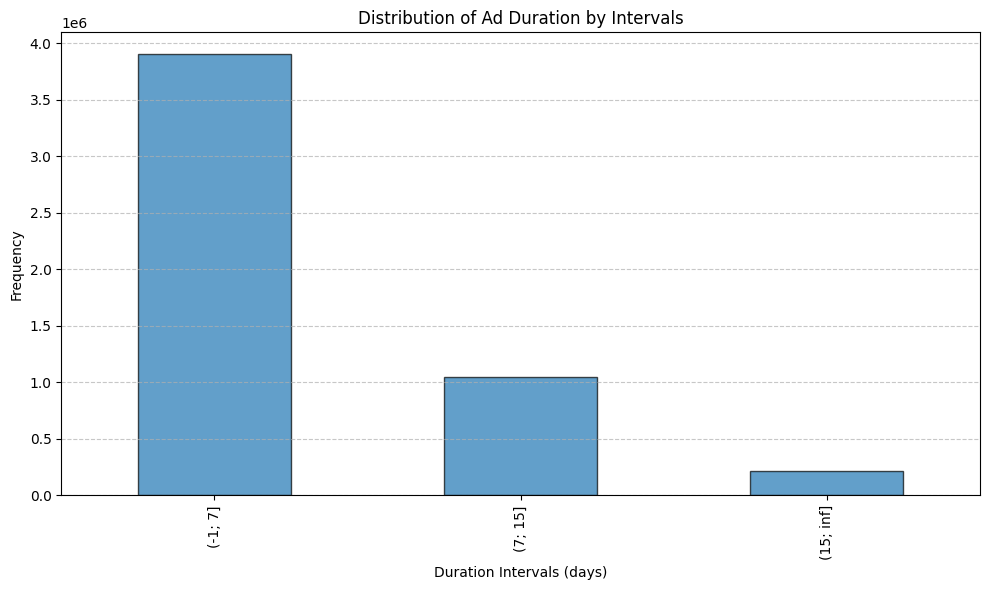

In [507]:
bins = [-1, 7, 15, float('inf')]
labels = ['(-1; 7]', '(7; 15]', '(15; inf]']

plt.figure(figsize=(10, 6))
pd.cut(data['ad_duration'], bins=bins, labels=labels, include_lowest=True).value_counts(sort=False).plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Distribution of Ad Duration by Intervals")
plt.xlabel("Duration Intervals (days)")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [541]:
data['ad_duration_power'] = pd.cut(
    data['ad_duration'],
    bins=[-1, 7, 15, float('inf')],
    labels=[0, 1, 2]
).astype(int)

In [534]:
data['is_multi_year'] = (data.ad_fin_years.apply(lambda x: x.split(":")).apply(lambda x: len(x)) > 1).astype(int)

In [ ]:
        # "ad_katos",
        # "participant_kato_list",
        # "participant_kopf_code",
        # "participant_branches",
        # "participant_parent_company",

In [536]:
data.participant_kopf_code.value_counts()

participant_kopf_code
ГУ     2729854
ГП     1801365
АО      308980
ТОО     169983
УЧР        600
Name: count, dtype: int64

In [544]:
data = pd.concat(
    [
        data,
        pd.get_dummies(data['participant_kopf_code'], prefix='is_participant_kopf').astype(int).drop(columns=['is_participant_kopf_УЧР'])
    ],
    axis=1
)

In [563]:
data['has_participant_branches'] = data['participant_branches'].apply(
    lambda x: [] if pd.isna(x) else x.split(":")
).apply(lambda x: len(x) > 0).astype(int)

In [570]:
data["has_participant_parent_company"] = data['participant_parent_company'].apply(
    lambda x: [] if pd.isna(x) else x.split(":")
).apply(lambda x: len(x) > 0).astype(int)

In [ ]:
####################################################################################################################################################################

In [268]:
# data.groupby('is_union_lots').size().reset_index(name="count")

# # data[
# #     [
# #         "total_count",
# #         "total_amount",
# #         "ad_lots_count"
# #     ]
# # ].corr()
# import seaborn as sns

# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='total_count', y='total_amount', data=data, alpha=0.5)
# plt.title('Relationship Between total_count and Target Variable')
# plt.xlabel('total_count')
# plt.ylabel('Target Variable')
# plt.show()


# #         # "total_count",        
# #         # "ad_lots_count",
# # # data[data.total_count > data.total_count.quantile(0.99)]
# # # data.total_count.quantile(quantiles)

# # plt.figure(figsize=(10, 6))
# # plt.hist(np.log1p(data[data.total_count <= data.total_count.quantile(0.99)]['total_count']+1), bins=100, edgecolor='black', alpha=0.7)
# # plt.title('Distribution of total_count')
# # plt.xlabel('Total Count')
# # plt.ylabel('Frequency')
# # plt.grid(axis='y', linestyle='--', alpha=0.7)
# # plt.show()

,is_union_lots,count
0,0,5087738
1,1,82415


In [451]:
# data.participant_kse_code.value_counts()

In [450]:
# data[data.fw_total_price_wdiscount == data.total_amount].participant_kse_code.value_counts()

In [452]:
# data[data.fw_total_price_wdiscount == data.total_amount].ad_subject_type_id.value_counts(), data.ad_subject_type_id.value_counts()

In [454]:
# (data['total_amount'] / data['fw_total_price_wdiscount']).quantile(quantiles)

In [427]:
# data[data.unearned_revenue_pct > 4000]
# # unearned_revenue_pct

In [68]:
# data.sw_total_price_wdiscount - data.fw_total_price_wdiscount

In [343]:
X = data[
    [
        "total_amount"
    ]
].rename(
    columns={
        "total_amount": "initial_lot_price",
    }
)
# .reset_index(drop=True)

y = data["sw_total_price_wdiscount"]

X["initial_lot_price"] = np.log2(X["initial_lot_price"] + 1)
# X["advertisement_total_price"] = np.log2(X["advertisement_total_price"] + 1)
y = np.log2(y + 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
# data['participant_is_small_employer'].value_counts() # возможно стоит исключить те у кого ad_fin_years == '0'

In [346]:
# xgb_model = xgb.XGBRegressor(
#     # learning_rate=0.1,
#     # max_depth=7,
#     # objective='reg:squarederror',
#     # random_state=42,
#     learning_rate=0.05,
#     max_depth=3,
#     n_estimators=100,
#     reg_lambda=1.0,  # L2 regularization
#     reg_alpha=0.5,   # L1 regularization
#     random_state=42
# )
# xgb_model.fit(X_train, y_train)

xgb_model = LinearRegression()
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2, np.sqrt(mse), mean_absolute_error(y_test, y_pred)

# (0.01799905104726207,
 # 0.979990650697431,
 # np.float64(0.13416054206532588),
 # 0.09223476723484725)

(0.18712031638672544,
 0.9811494578645338,
 np.float64(0.4325740588462575),
 0.30532992669210124)

In [347]:
y_pred_actual = (2 ** y_pred) - 1
y_test_actual = (2 ** y_test) - 1

mae_actual = mean_absolute_error(y_test_actual, y_pred_actual)
mse_actual = mean_squared_error(y_test_actual, y_pred_actual)
rmse_actual = np.sqrt(mse_actual)
r2_actual = r2_score(y_test_actual, y_pred_actual)

mse_actual, r2_actual, rmse_actual, mae_actual, 

(458457218892258.9,
 0.9240833450522461,
 np.float64(21411614.1122583),
 686678.0931582405)

In [322]:
# # np.power(10, y.median()) - 1
# np.log2(data.sw_total_price_wdiscount + 1).quantile([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0])
# # y_test.quantile(0.99)

0.00     0.014355
0.01     9.967226
0.05    11.551218
0.10    12.399011
0.25    13.945901
0.50    15.861111
0.75    18.015638
0.90    20.291091
0.95    21.826872
0.99    24.757086
1.00    35.511469
Name: sw_total_price_wdiscount, dtype: float64

In [348]:
y_pred = np.power(2, xgb_model.predict(X_test)) - 1
y_test_actual = np.power(2, y_test) - 1

mae = mean_absolute_error(y_test_actual, y_pred)
over_predictions = np.sum(y_pred > y_test_actual) / len(y_test_actual) * 100

# Output metrics
print(f"MAE: {mae}")
print(f"Percentage of Over-Predictions: {over_predictions}%")

MAE: 686678.0931582405
Percentage of Over-Predictions: 37.601587175678205%


In [334]:
data[np.log2(data.sw_total_price_wdiscount + 1) < 24.8].total_amount.median()

np.float64(70.0)

In [337]:
np.log2(data.sw_total_price_wdiscount + 1).quantile([0.99, 1.0])

0.99    24.757086
1.00    35.511469
Name: sw_total_price_wdiscount, dtype: float64

In [302]:
np.log2(X["advertisement_total_price"] + 1).quantile()

1          2.677137
2          2.677608
3          2.500298
4          2.662432
5          2.453422
             ...   
6034216    2.794420
6034217    2.321941
6034218    2.535029
6034219    2.759011
6034220    2.865926
Name: advertisement_total_price, Length: 5269412, dtype: float64

In [349]:
# X = data[(~data.sw_total_price_wdiscount.isna()) & (data.fw_total_price_wdiscount > 0)][['fw_total_price_wdiscount']]
# y = data[(~data.sw_total_price_wdiscount.isna()) & (data.fw_total_price_wdiscount > 0)]['sw_total_price_wdiscount']

# X['fw_total_price_wdiscount'] = np.log10(X['fw_total_price_wdiscount'] + 1)
# y = np.log10(y + 1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model
mae = mean_absolute_error(np.power(2, y_test) - 1, (np.power(2, y_pred) - 1))
over_predictions = np.sum(y_pred > y_test) / len(y_test) * 100

{
    "MAE": mae,
    "Percentage of Over-Predictions": over_predictions,
    "Example Predictions": list(zip(y_test[:10], y_pred[:10]))
}

{'MAE': 686678.0931582405,
 'Percentage of Over-Predictions': np.float64(37.601587175678205),
 'Example Predictions': [(15.25122349523062, np.float64(15.408058092807513)),
  (14.55078285230843, np.float64(15.214461625477368)),
  (13.358239100426132, np.float64(13.381796090988713)),
  (21.089998580102538, np.float64(20.674796995127295)),
  (18.620871308634023, np.float64(18.28270353369843)),
  (16.439587428127545, np.float64(17.082843172871446)),
  (18.096300278844325, np.float64(17.72658033713662)),
  (20.437460515036197, np.float64(20.674796995127295)),
  (17.39205742710167, np.float64(17.379555865149108)),
  (16.287730413124752, np.float64(15.940919933912603))]}

In [351]:
from sklearn.tree import DecisionTreeRegressor

# X = data[(~data.sw_total_price_wdiscount.isna()) & (data.fw_total_price_wdiscount > 0)][['fw_total_price_wdiscount']]
# X['fw_total_price_wdiscount'] = np.log10(X['fw_total_price_wdiscount'] + 1)

# y = data[(~data.sw_total_price_wdiscount.isna()) & (data.fw_total_price_wdiscount > 0)]['sw_total_price_wdiscount']
# y_transformed = np.log10(y + 1)

# Train-test split remains the same, reuse X_train, X_test
# X_train, X_test, y_train_transformed, y_test_transformed = train_test_split(
#     X, y_transformed, test_size=0.4, random_state=42
# )

# Train a Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42, max_depth=5)
tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_transformed = tree_model.predict(X_test)

# Reverse the log10 transformation
y_pred = np.power(2, y_pred_transformed) - 1
y_test_actual = np.power(2, y_test) - 1

# Evaluate the Decision Tree model
mae_tree = mean_absolute_error(y_test_actual, y_pred)
over_predictions_tree = np.sum(y_pred > y_test_actual) / len(y_test_actual) * 100

# Display results
{
    "MAE": mae_tree,
    "Percentage of Over-Predictions": over_predictions_tree,
    "Example Predictions": list(zip(y_test_actual[:10], y_pred[:10]))
}


{'MAE': 1432362.1586402645,
 'Percentage of Over-Predictions': np.float64(40.60395243520775),
 'Example Predictions': [(39000.0, np.float64(43474.91108556567)),
  (23999.599999999988, np.float64(35410.88467347889)),
  (10500.000000000005, np.float64(11775.43063283814)),
  (2232142.859999998, np.float64(1419668.3113071886)),
  (403124.9999999998, np.float64(357991.82150277914)),
  (88880.0, np.float64(144759.23250309305)),
  (280238.40000000014, np.float64(195579.2687896759)),
  (1419999.9999999998, np.float64(1419668.3113071886)),
  (172000.00000000015, np.float64(144759.23250309305)),
  (80000.00000000006, np.float64(54510.058062247175))]}

In [354]:
import xgboost as xgb
import numpy as np

def custom_asymmetric_loss(y_true, y_pred):
    alpha = 0.2  # Penalize over-predictions more
    residual = y_pred - y_true  # Difference between predicted and true values
    gradient = np.where(residual > 0, 2 * alpha * residual, 2 * (1 - alpha) * residual)
    hessian = np.where(residual > 0, 2 * alpha, 2 * (1 - alpha))
    return gradient, hessian

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {"max_depth": 5, "eta": 0.05}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    obj=lambda y_pred, dtrain: custom_asymmetric_loss(dtrain.get_label(), y_pred),
    evals=[(dtest, "test")],
)


[0]	test-rmse:15.16092
[1]	test-rmse:14.40355
[2]	test-rmse:13.68406
[3]	test-rmse:13.00057
[4]	test-rmse:12.35131
[5]	test-rmse:11.73454
[6]	test-rmse:11.14864
[7]	test-rmse:10.59209
[8]	test-rmse:10.06342
[9]	test-rmse:9.56122
[10]	test-rmse:9.08418
[11]	test-rmse:8.63105
[12]	test-rmse:8.20063
[13]	test-rmse:7.79180
[14]	test-rmse:7.40347
[15]	test-rmse:7.03462
[16]	test-rmse:6.68428
[17]	test-rmse:6.35152
[18]	test-rmse:6.03550
[19]	test-rmse:5.73535
[20]	test-rmse:5.45030
[21]	test-rmse:5.17959
[22]	test-rmse:4.92251
[23]	test-rmse:4.67839
[24]	test-rmse:4.44657
[25]	test-rmse:4.22646
[26]	test-rmse:4.01747
[27]	test-rmse:3.81905
[28]	test-rmse:3.63068
[29]	test-rmse:3.45187
[30]	test-rmse:3.28215
[31]	test-rmse:3.12105
[32]	test-rmse:2.96817
[33]	test-rmse:2.82309
[34]	test-rmse:2.68544
[35]	test-rmse:2.55484
[36]	test-rmse:2.43096
[37]	test-rmse:2.31347
[38]	test-rmse:2.20205
[39]	test-rmse:2.09642
[40]	test-rmse:1.99627
[41]	test-rmse:1.90136
[42]	test-rmse:1.81142
[43]	test-rm

In [356]:
# Make predictions
y_pred_transformed = model.predict(dtest)
y_pred = np.power(2, y_pred_transformed) - 1
y_test_actual = np.power(2, y_test) - 1

# Evaluate results
mae = mean_absolute_error(y_test_actual, y_pred)
over_predictions = np.sum(y_pred > y_test_actual) / len(y_test_actual) * 100

# Output metrics
print(f"MAE: {mae}")
print(f"Percentage of Over-Predictions: {over_predictions}%")


MAE: 1826068.8810439194
Percentage of Over-Predictions: 40.753764224007384%


In [39]:
data[(data.sw_total_price_wdiscount == 0) & (data.sw_total_price_wdiscount != data.fw_total_price_wdiscount)]

,advertisement_id,lot_id,fw_item_price,fw_total_price,fw_discount,fw_total_price_wdiscount,sw_item_price,sw_total_price,sw_discount,sw_total_price_wdiscount,...,participant_parent_company,participant_oked_list,participant_kse_code,participant_is_world_company,participant_is_state_monopoly,participant_is_natural_monopoly,participant_is_patronymic_producer,participant_is_patronymic_supplier,participant_is_small_employer,participant_is_single_org
